# Úkoly 
1. vykreslete grafy prvních 5 Legendrových polynomů na intervalu [-1,1]

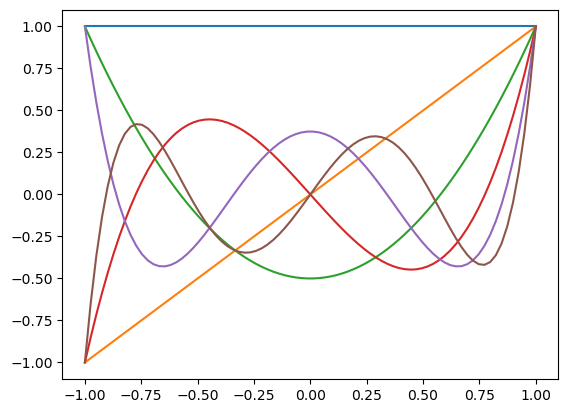

In [17]:
# pouziju tzv. bonnetuv rekurentni vzorec
import numpy as np
import matplotlib.pyplot as plt

def legendre(x, n):
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return ((2*n-1)*x*legendre(x,n-1) - (n-1)*legendre(x,n-2))/n

fig, ax = plt.subplots()
interval = np.linspace(start = -1, stop = 1, num = 80)
for i in range(6):
    ax.plot(interval, [legendre(x, i) for x in interval])

2. vyrobte sparse matici reprezentující čtvercovou síť o velikosti $n \times n$, kde každá buňka sítě odpovídá jednomu řádku/sloupci matice. V každém řádku/sloupci matice jsou nuly, kromě diagonálního prvku s hodnotou $1 + k \cdot \varepsilon$ (kde $k$ určuje počet sousedních buněk = 4 uvnitř, 3 na hranách, 2 v rozích) a prvků odpovídajícím sousedním buňkám (nahoře, dole, vlevo, vpravo) s hodnotou $-\varepsilon$. Pořadí buněk čtvrtcové sítě berte po řádcích. Sestavte matici pomocí formátu LIL a vyplňte hodnoty pomocí cyklu přes všechny buňky sítě.
    - tedy matice má velikost $n^2 \times n^2$
    - $\varepsilon$ je parametr, který můžete nastavit, například $\varepsilon = 0.1$
    - matice je symetrická, tj. $A = A^T$
    - každý řádek/sloupec má maximálně 5 nenulových prvků
        - 5, pokud se jedná o buňku unvitř sítě
        - 4, pokud se jedná o buňku na okraji sítě
        - 3, pokud se jedná o buňku v rohu sítě
    - výsledná matice je 5-ti diagonální

Pro $n=3$ a $\varepsilon = 0.1$ by měla matice (v plné formě) měla vypadat následovně:
```python
[[ 1.2 -0.1  0.  -0.1  0.   0.   0.   0.   0. ]
 [-0.1  1.3 -0.1  0.  -0.1  0.   0.   0.   0. ]
 [ 0.  -0.1  1.2  0.   0.  -0.1  0.   0.   0. ]
 [-0.1  0.   0.   1.3 -0.1  0.  -0.1  0.   0. ]
 [ 0.  -0.1  0.  -0.1  1.4 -0.1  0.  -0.1  0. ]
 [ 0.   0.  -0.1  0.  -0.1  1.3  0.   0.  -0.1]
 [ 0.   0.   0.  -0.1  0.   0.   1.2 -0.1  0. ]
 [ 0.   0.   0.   0.  -0.1  0.  -0.1  1.3 -0.1]
 [ 0.   0.   0.   0.   0.  -0.1  0.  -0.1  1.2]]
 ```


In [18]:
import scipy.sparse as sparse

# efektivnejsi implementace na zaklade rad
def A_inefficiently(n, eps):
    A = sparse.lil_matrix((n*n, n*n))
    for i in range(n):
        for j in range(n):
            k = 0
            if j > 0:
                A[i*n+j,i*n+j-1] = -eps # vlevo
                k += 1
            if j < n-1:
                A[i*n+j,i*n+j+1] = -eps # vpravo
                k += 1
            if i > 0:
                A[i*n+j,i*n+j-n] = -eps # nahore
                k += 1
            if i < n-1:
                A[i*n+j,i*n+j+n] = -eps # dole
                k += 1

            A[i*n+j, i*n+j] = 1+k*eps
    return A

3. sestavte matici $A$ z předchozího úkolu pomocí indexů řádků, sloupců a hodnot ve formátu CSR. 
    - Tedy sestavte tři pole: `row`, `col` a `data`, které obsahují řádky, sloupce a hodnoty nenulových prvků matice 
        - separátně sestavte příspěvky které vzniknou konektivitou na vnitřních horizontálních hranách a na vnitřních vertikálních hranách.
            - při procházení všech vnitřních horizontálních hran si rozmyslete jaké jsou vždy indexy nad a pod hranou (toto jsou souřadnice řádků a sloupců)
            - totéž pro vnitřní vertikální hrany zde se může hodit `np.arange(n * n).reshape((n, n)).T.flatten()` což vytvoří vektor s přeházenými indexy
        - zvlášť sestavte příspevky pro mimodiagonální prvky a diagonální prvky.
            - u diagonálních prvků, nejprve vyrobte vektor hodnot $1+ 4\cdot \varepsilon$ a pak pro každou hranu odečtěte $\varepsilon$.
    - Tyto pole vytvořte vektorizovaně - bez cyklů
    - Využíjte vlastnosti, že hodnoty se stejnými indexy se při sestavení sečtou.

In [19]:
# neni to uplne elegantni reseni, ale melo by fungovat spravne a funguje rychleji nez predchozi reseni

def A_efficiently(n, eps):
    def generate(e, vals, id):
        e_n = [e + np.full(e.shape,i) for i in vals] # only 4 or 3 or 2 iterations
        cols = np.hstack((e,*e_n))
        rows = np.tile(e, len(e_n)+1)
        vals = np.hstack((np.full(e.shape, 1+id*eps), np.full(cols.size - e.size, -eps)))
        return rows, cols, vals

    # works for n >= 3
    if n >= 3:
        nums = np.arange(n**2)
        step = n - 2
        ne = nums[1:step+1] #north edge
        se = nums[-1-step:-1] #south edge
        we = nums[n:n**2-2*n+1:n] #west edge
        ee = nums[2*n-1:n**2-n+1:n] #east edge

        ne_rows, ne_cols, ne_vals = generate(ne, [1,-1,n], 3)
        se_rows, se_cols, se_vals = generate(se, [1,-1,-n], 3)
        we_rows, we_cols, we_vals = generate(we, [1,n,-n], 3)
        ee_rows, ee_cols, ee_vals = generate(ee, [-1,n,-n], 3)

        nwc_rows, nwc_cols, nwc_vals = generate(np.array([0]), [1,n],2) # north west corner
        nec_rows, nec_cols, nec_vals = generate(np.array([n-1]),[-1,n],2) # north east corner
        swc_rows, swc_cols, swc_vals = generate(np.array([n**2-n]),[1,-n],2) # north west corner
        sec_rows, sec_cols, sec_vals = generate(np.array([n**2-1]),[-1,-n],2) # north east corner

        mid = np.arange(n**2).reshape(n,n)[1:-1,1:-1].flatten() # not very good solution
        mid_rows, mid_cols, mid_vals = generate(mid, [1,-1,n,-n], 4)

        row_idx_diag = np.hstack((ne_rows, se_rows, we_rows, ee_rows, nwc_rows, nec_rows, swc_rows, sec_rows, mid_rows))
        col_idx_diag = np.hstack((ne_cols, se_cols, we_cols, ee_cols, nwc_cols, nec_cols, swc_cols, sec_cols, mid_cols))
        data = np.hstack((ne_vals, se_vals, we_vals, ee_vals, nwc_vals, nec_vals, swc_vals, sec_vals, mid_vals))

        A_efficiently = sparse.csr_matrix((data, (row_idx_diag, col_idx_diag)), shape=(n**2, n**2))

        return A_efficiently

In [20]:
from time import time
n = 170
eps = 1e-1

t1 = time()
A = A_inefficiently(n,eps).todense()
t2 = time()
B = A_efficiently(n, eps).todense()
t3 = time()
print(t2-t1)
print(t3-t2)
# print(np.array_equal(A,B))

0.8520517349243164
0.3475806713104248


4. Použijte matici $A$ z předchozích úkolů. Vytvořte (použijte níže vytvořený) vektor $b$ odpovídající čtvercové síti s nulami všude kromě malého čtverce uprostřed ($n/6$ okolo středu) s hodnotou 1. 
    - Vykreslete řešení $x$ systému $A \cdot x = b$ jako obrázek čtvercové sítě
    - Spočtěte a vizualizujte 3 vlastní vektory matice $A$ (vlastní vektory odpovídající největším vlastním hodnotám) - opět jako obrázek čtvercové sítě

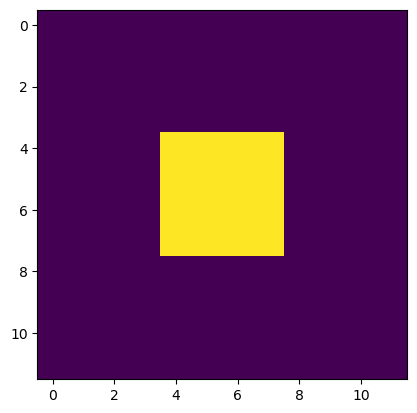

In [22]:
import matplotlib.pyplot as plt

n = 12
epsilon = 2e-1
A = A_efficiently(n, epsilon)


b = np.zeros((n, n))
b[n//2 - n//6:n//2 + n//6,n//2 - n//6:n//2 + n//6] = 1
b = b.flatten()
plt.imshow(b.reshape((n, n)))

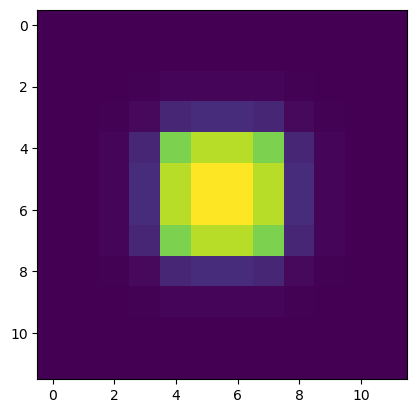

In [23]:
import scipy as sp

# TODO - vyřešte lineární rovnici A x = b a vykreselete výsledek
x = sp.sparse.linalg.spsolve(A,b)
plt.imshow(x.reshape(n,n))

C:\Users\pepaz\AppData\Local\Temp\ipykernel_15480\4216439134.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  evect = evect.reshape(n,n).astype("float")


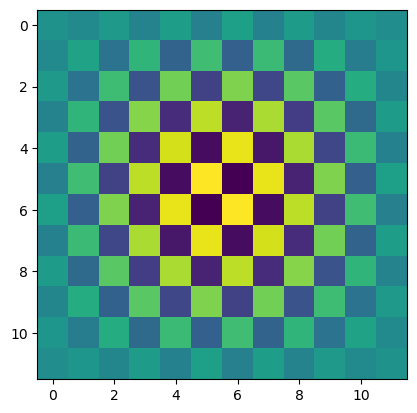

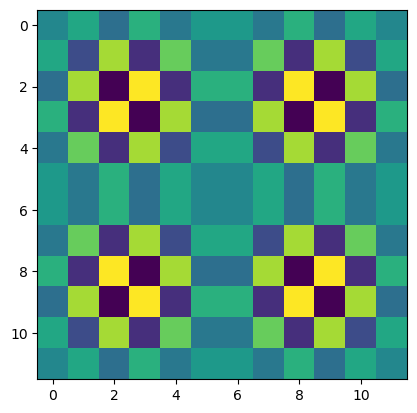

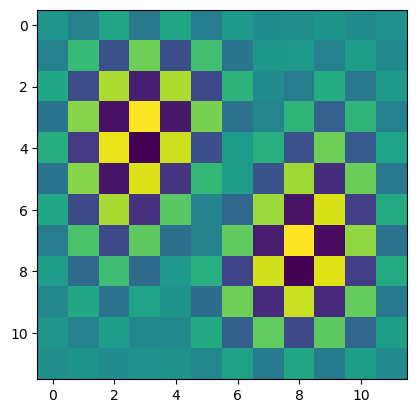

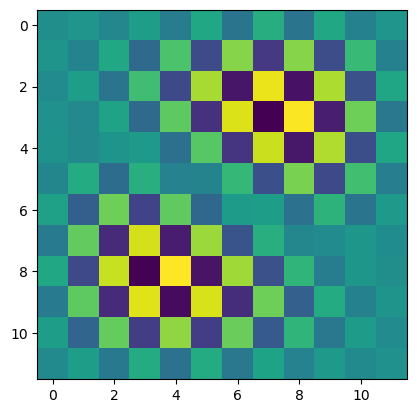

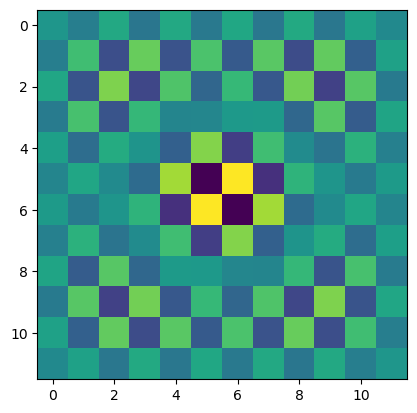

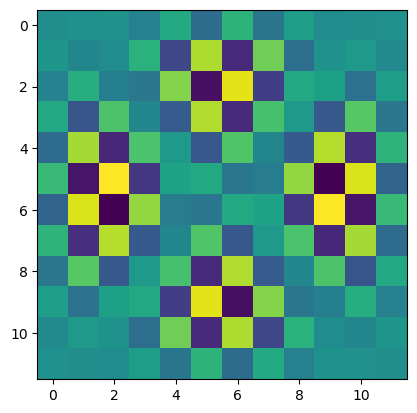

In [24]:
# TODO - spočtěte a vykreslete vlastní vektory matice A
evectors = sp.sparse.linalg.eigs(A)[1]
for i in range(6):
    evect = evectors[:,i]
    evect = evect.reshape(n,n).astype("float")
    plt.figure()
    plt.imshow(evect)


5. Nalezněte všechny kořeny Legendrova polynomu stupně 5 na intervalu $<-1,1>$

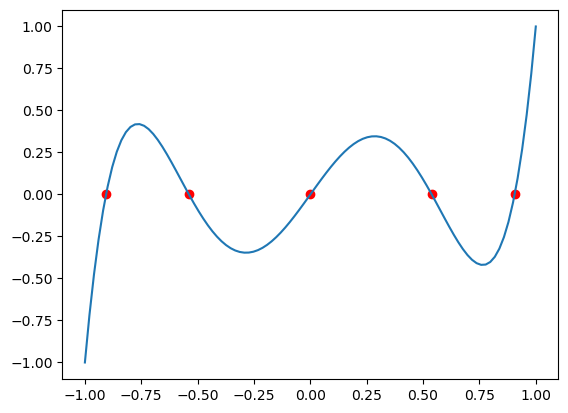

In [25]:
# poznamka - kdybych postupoval rucne musel bych hledat intervaly, kde se meni znamenka a pote hledat jednotlive koreny pomoci standartnich numerickych metod jako treba riddersova nebo newtonova

import numpy as np
degree = 5
polynomial = np.polynomial.legendre.Legendre([0]*degree + [1])
roots = polynomial.roots()

fig, ax = plt.subplots()
interval = np.linspace(start=-1,stop=1,num=100)
ax.plot(interval, [polynomial(i) for i in interval])
ax.scatter(roots, [polynomial(i) for i in roots], color="red");

6. Pomocí SymPy nalezněte všechny kořeny Legendrova polynomu stupně 5. Použíjte `sympy.legendre()` pro vytvoření výrazu odpovídajícímu Legendrovu polynomu.
- porovnejte výsledky s předchozím úkolem

In [26]:
import sympy as sp
from math import sqrt

x = sp.Symbol('x')
legendre_ = sp.legendre(5, x)

sp_koreny = [float(i) for i in list(sp.roots(legendre_))]
sp_koreny = np.sort(np.array(sp_koreny))
roots = np.sort(roots)
rozdil = np.linalg.norm(sp_koreny - roots)
print(rozdil)

1.1273312171982056e-15
